# Facies Classification


**What are Facies?**  
Sedimentary facies are bodies of sediment that are recognizably distinct from adjacent sediments that resulted from different depositional environments. Generally, geologists distinguish facies by the aspect of the rock or sediment being studied.  

**Why are Facies important?**  
Important first step in exploration, prospecting, resevoir classification, & field development.  

**How data is collected**  
Using Seismic reflectors.   Method of exploration geophysics that provides information about the sub-surface structure of the seafloor. The general principle involves sending artificially generated acoustic waves down the water column and into the seafloor, where the different structures and objects within the Earth's crust reflect this energy back according to their acoustic impedance. These reflected energy waves are recorded by hydrophones, and the data are processed to produce a visual representation of the seabed sub-surface.  


**The nine discrete facies (classes of rocks) are:**   
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


Variable |Label| Description
:---: | :---: |:--:
Gamma ray |GR| Spontaneous emission of gamma ray from rocks
Resistivity |ILD_log10| Resistivity of the mud
Photoelectric effect |PE| Light shines on a metal
Neutron-density porosity difference |DeltaPHI| Neutron density of a formation difference
Average neutron-density porosity |PHIND| Average neutron density of a formation
Nonmarine/marine indicator |NM_M| Indicator of organic material
Relative position |RELPOS| Relative position of geological strata

In [1]:
import xgboost as xgb
print(xgb.__version__)

0.90


In [2]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
#from pandas.tools.plotting import scatter_matrix
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from classification_utilities import display_cm, display_adj_cm

In [3]:
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = '../data/training_data_clean.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,WellName,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [4]:
training_data['WellName'] = training_data['WellName'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
Facies       3232 non-null int64
Formation    3232 non-null category
WellName     3232 non-null category
Depth        3232 non-null float64
GR           3232 non-null float64
ILD_log10    3232 non-null float64
DeltaPHI     3232 non-null float64
PHIND        3232 non-null float64
PE           3232 non-null float64
NM_M         3232 non-null int64
RELPOS       3232 non-null float64
dtypes: category(2), float64(7), int64(2)
memory usage: 234.8 KB


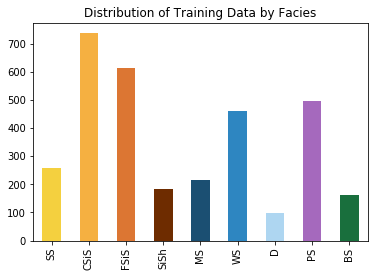

In [5]:
#Find distributions of training Data
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72',
                 '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

facies_counts = training_data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

Would like to understand the more valuable Facies to keep track of and why Nonmarine coarse siltstone/CSIS and Nonmarine fine siltstone/FSis have the largest distributions.  

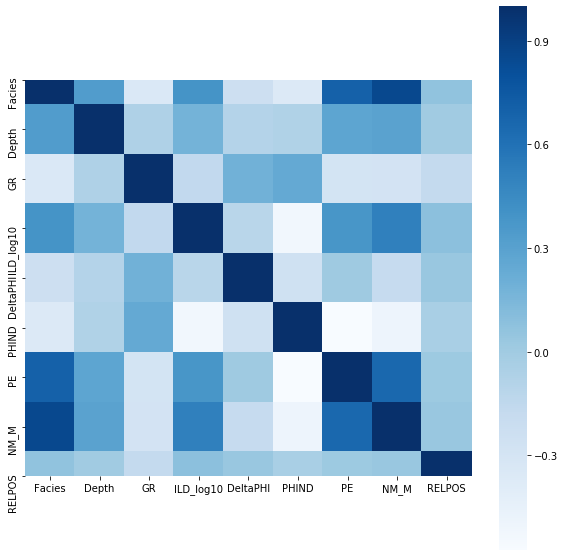

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(training_data.corr(), cmap="Blues", square=True)


Correlation plot to observe relationship between variables.  
Target variable **Facies** is highly correlated to the following variables:  
ILD_log10, PE, and NM_M  

# Data Analysis
---
XGboost an algorithim used for machine learning for structured or tabular data.  
Implementation of gradient boosted decision trees decsigned for speed and performance.

In [7]:
X_train = training_data.drop(['Facies','WellName','Formation','Depth'], axis = 1 ) 
Y_train = training_data['Facies' ] - 1
dtrain = xgb.DMatrix(X_train, Y_train)
type(Y_train)

/Users/johnvictorifermo/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


pandas.core.series.Series

In [8]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


Cross Validation Training Report Summary
     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
495           0.098014          0.001482          0.291675         0.023596
496           0.097739          0.001653          0.291366         0.023946
497           0.097292          0.001795          0.291994         0.024048
498           0.096879          0.001719          0.291680         0.023979
499           0.096845          0.001784          0.291994         0.024048

Model Report
-Accuracy: 0.898205
-Adjacent Accuracy: 0.981436

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   218    38     3                                       259
     CSiS     7   685    46                                       738
     FSiS          70   543                 1           1         615
     SiSh           1     1   163          13           6         184
       MS           2     1     3   183    21           7    

Text(0, 0.5, 'Feature Importance Score')

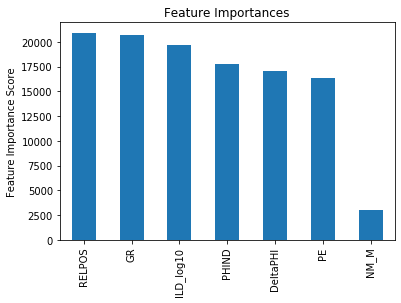

In [9]:
%%time
# Cross Validation parameters
cv_folds = 10
rounds = 100 

# Proposed Initial Model
xgb1 = xgb.XGBClassifier( learning_rate =0.01, n_estimators=500, max_depth=6,
                          min_child_weight=1, gamma=0, subsample=0.8,
                          colsample_bytree=0.8, objective='multi:softmax',
                          nthread=4, scale_pos_weight=1, seed=27)

xgb_param_1 = xgb1.get_xgb_params()
xgb_param_1['num_class'] = 9

# Perform cross-validation
cvresult = xgb.cv(xgb_param_1, dtrain, num_boost_round=xgb_param_1['n_estimators'], 
                  stratified = True, nfold=cv_folds, metrics='merror', early_stopping_rounds=rounds)

print("\nCross Validation Training Report Summary")
print(cvresult.tail())

xgb1.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
xgb1.fit(X_train, Y_train,eval_metric='merror')

#Predict training set:

predictions = xgb1.predict(X_train)
        
#Print model report

# Confusion Matrix
conf = confusion_matrix(Y_train, predictions )

# Print Results
print("\nModel Report")
print("-Accuracy: %.6f" % ( accuracy(conf) ))
print("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))

print("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)
# Print Feature Importance
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [10]:
# #Different Cross Val_score  with no tuning
# from sklearn.model_selection import cross_val_score
# from xgboost import XGBClassifier

# xgb3=XGBClassifier()

# scores=cross_val_score(xgb1, X_train, Y_train, cv=3, scoring='f1_macro')
# print("Mean score: {}. Standard deviation {}".format(scores.mean(), scores.std()))
#Got a score of Mean score: 0.47286917221208186. Standard deviation 0.05135143762057667

In [11]:
# #Show feature importance score
# name=X_train.columns
# imp_score=xgb1.feature_importances_
# imp_data=pd.DataFrame({})
# for i in range(len(name)):
#     imp_data[name[i]]=[imp_score[i]]
# imp_data.plot(kind = 'bar', title ="Feature Importance")
# plt.xlabel('Features')
# plt.show()

In [12]:
print("Parameter optimization")
grid_search1 = GridSearchCV(xgb1,{'learning_rate':[0.001,0.01,0.05] , 'n_estimators':[100,200,500]},
                                   scoring='accuracy' , n_jobs = 4)
grid_search1.fit(X_train,Y_train)
print("Best Set of Parameters")
grid_search1.cv_results_, grid_search1.best_params_, grid_search1.best_score_

Parameter optimization


/Users/johnvictorifermo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Set of Parameters


({'mean_fit_time': array([ 4.08487558,  8.44915485, 20.390968  ,  4.07447902,  8.15312052,
         24.98362803,  5.4610556 ,  8.59291458, 20.23763267]),
  'std_fit_time': array([0.06772729, 0.10552927, 0.39892861, 0.08480875, 0.07597256,
         0.29738275, 1.97845623, 0.44415189, 0.35287662]),
  'mean_score_time': array([0.13541365, 0.30846357, 1.32822434, 0.12865925, 0.29214478,
         1.70695297, 0.17985129, 0.28032907, 2.09800625]),
  'std_score_time': array([0.00526467, 0.00877326, 0.07022219, 0.00873655, 0.03614608,
         0.04221084, 0.03366374, 0.01923584, 0.62264572]),
  'param_learning_rate': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.05, 0.05,
                     0.05],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[100, 200, 500, 100, 200, 500, 100, 200, 500],
               mask=[False, False, Fa

In [13]:
#Final Model
cv_folds = 10
rounds = 100
xgb_final = xgb.XGBClassifier( learning_rate =0.001, n_estimators=500, max_depth=6,
                               min_child_weight=1, gamma=0, subsample=0.8, reg_alpha = 1,
                               colsample_bytree=0.8, objective='multi:softmax',
                               nthread=4, scale_pos_weight=1, seed=27)

xgb_param_final = xgb_final.get_xgb_params()
xgb_param_final['num_class'] = 9

# Perform cross-validation
cvresult = xgb.cv(xgb_param_final, dtrain, num_boost_round=xgb_param_final['n_estimators'], 
                  nfold=cv_folds, metrics='merror', early_stopping_rounds=rounds)

print("\nCross Validation Training Report Summary")
print(cvresult.tail())

xgb_final.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
xgb_final.fit(X_train, Y_train,eval_metric='merror')

#Predict training set:
predictions = xgb_final.predict(X_train)
        
#Print model report

# Confusion Matrix
print("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

# Print Results
print("\nModel Report")
print("-Accuracy: %.6f" % ( accuracy(conf) ))
print("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))


Cross Validation Training Report Summary
     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
241           0.253919          0.003234          0.341899         0.031481
242           0.253851          0.003214          0.342517         0.031224
243           0.253885          0.003019          0.342517         0.031224
244           0.253885          0.003321          0.342208         0.031714
245           0.254126          0.003001          0.341588         0.031649

Confusion Matrix
     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS   218    38     3                                       259
     CSiS     7   685    46                                       738
     FSiS          70   543                 1           1         615
     SiSh           1     1   163          13           6         184
       MS           2     1     3   183    21           7         217
       WS           1           4     6   424     1   

# Results

Check performance of model

In [14]:
# Import data
%%time
filename = '../data/training_data_clean.csv'
data = pd.read_csv(filename)

data['WellName'] = data['WellName'].astype('category')
data['Formation'] = data['Formation'].astype('category')

# Leave out one well for prediction
well_names = data['WellName'].unique()
f1=[]
for i in range(len(well_names)):
    
    # Split data
    X_train = data.drop(['Facies', 'Formation','Depth'], axis = 1 ) 
    Y_train = data['Facies' ] - 1
    
    train_X = X_train[X_train['WellName'] != well_names[i] ]
    train_Y = Y_train[X_train['WellName'] != well_names[i] ]
    test_X  = X_train[X_train['WellName'] == well_names[i] ]
    test_Y  = Y_train[X_train['WellName'] == well_names[i] ]

    train_X = train_X.drop(['WellName'], axis = 1 ) 
    test_X = test_X.drop(['WellName'], axis = 1 )

    # Model
    model_final = xgb.XGBClassifier( learning_rate =0.001, n_estimators=500, max_depth=6,
                                   min_child_weight=1, gamma=0, subsample=0.8, reg_alpha = 10,
                                   colsample_bytree=0.8, objective='multi:softmax',
                                   nthread=4, scale_pos_weight=1, seed=27)

    #Fit the algorithm on the data
    model_final.fit( train_X , train_Y , eval_metric = 'merror' )

    # model_final = RandomForestClassifier(n_estimators=1000) # RANDOM FORREST
    #model_final.fit(train_X, train_Y)

    #Predict training set:
    predictions = model_final.predict(test_X)

    #Print model report
    print("\n------------------------------------------------------")
    print("Leaving out well " + well_names[i])
    # Confusion Matrix
    conf = confusion_matrix( test_Y, predictions, labels = np.arange(9) )
    # Print Results
    print("\nModel Report")
    print("-Accuracy: %.6f" % ( accuracy(conf) ))
    print("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
    print("-F1 Score: %.6f" % ( f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ) ))
    f1.append(f1_score ( test_Y , predictions , labels = np.arange(9), average = 'weighted' ))
    facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                     'WS', 'D','PS', 'BS']
    print("\nConfusion Matrix Results")
    from classification_utilities import display_cm, display_adj_cm
    display_cm(conf, facies_labels,display_metrics=True, hide_zeros=True)
    
print("\n------------------------------------------------------")
print("Final Results")
print("-Average F1 Score: %6f" % (sum(f1)/(1.0*len(f1))))

UsageError: Line magic function `%%time` not found.
